In [1]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

images/download.jpeg


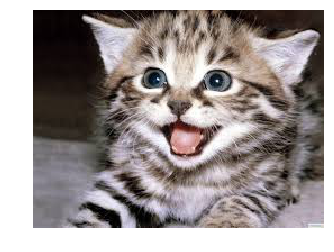

AttributeError: 'NodeLookup' object has no attribute 'node_lookup'

In [2]:
class NodeLookup(object):
    def _init_(self):
        label_lookup_path='inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path='inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup=self.load(label_lookup_path,uid_lookup_path)
        
    def load(self,label_lookup_path,uid_lookup_path):
#         加载分类字符串n******对应分类名称的文件
        proto_as_ascii_lines=tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human={}
#         一行一行读取数据
        for line in proto_as_ascii_lines:
#             去掉换行符
            line=line.strip('\n')
#           按照'/t'分割
            parsed_items=line.split('\t')
#           获取分类编号
            uid=parsed_items[0]
#           获取分类名称
            human_string=parsed_items[1]
#           保存编号字符串n******与分类名称映射关系
            uid_to_human[uid]=human_string
    
#        加载分类字符串n******对应分类编号1-1000的文件
        proto_as_ascii=tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid={}
        for line in proto_as_ascii:
            if line.startswith(' target_class:'):
                target_class=int(line.split(': ')[1])#获取分类编号1-1000
            if line.startswith(' target_class_string'):
                target_class_string=line.split(': ')[1]
                #保存分类编号1-1000与编号字符串n*****映射关系
                node_id_to_uid[target_class]=target_class_string[1:-2]

#         建立分类编号1-1000对应分类名称的映射关系        
        node_id_to_name={}
        for key,val in node_id_to_uid.items():
            name=uid_to_human[val]#获取分类名称
            node_id_to_name[key]=name#建立分类编号1-1000到分类名称的映射关系
        return node_id_to_name
    
    
#     传入分类编号1-1000返回分类名称
    def id_to_string(self,node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]
    
#     创建一个图来存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb','rb') as f:
    graph_def=tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')
    
with tf.Session() as sess:
    softmax_tensor=sess.graph.get_tensor_by_name('softmax:0')
#     遍历目录
    for root,dirs,files in os.walk('images/'):
        for file in files:
            image_data=tf.gfile.FastGFile(os.path.join(root,file),'rb').read()
            predictions=sess.run(softmax_tensor,{'DecodeJpeg/contents:0':image_data})
            predictions=np.squeeze(predictions)#把结果转为1维数据
            
            image_path=os.path.join(root,file)
            print(image_path)
            
            img=Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            
#             排序
            top_k=predictions.argsort()[-5:][::-1]
            node_lookup=NodeLookup()
            for node_id in top_k:
                human_string=node_lookup.id_to_string(node_id)
                score=predictions[node_id]
                print('%s (score=%.5f)' %(human_string,score))
            print()







    